<a href="https://colab.research.google.com/github/Artin-Tavasoli/Clustering/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
   <font size="+3">🧠 Clustering</font>
</p>

<p align="center">
  <font size="+2">Artin Tavasoli 👋🏻</font>
</p>
<p align="center">
  <font size="+2">📘 Student ID: 810102543</font>
</p>

* * *

  <font size="+2">Overview</font>

  Clustering is an unsupervised machine learning technique used to group similar data points together based on their inherent characteristics. We will explore various clustering methods, including Hierarchical Clustering, DBSCAN, and K-Means, applied to a music lyrics dataset.


Replace the placeholder URL below with the raw GitHub URL of your CSV file.

## 📚 Import Needed Libraries


In [76]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from spellchecker import SpellChecker
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer


## ⏳ Load Dataset

In [62]:
dataset_url = 'https://raw.githubusercontent.com/Artin-Tavasoli/Clustering/refs/heads/main/musicLyrics.csv'
music_df = pd.read_csv(dataset_url)
print("dataset file loaded successfully!")
display(music_df.head())

dataset file loaded successfully!


,Lyric
0,Cryptic psalms Amidst the howling winds A scor...
1,Im sleeping tonight with all the wolves Were d...
2,Wings of the darkest descent Fall from the rea...
3,[Verse 1] Norrid Radd was my real name Had a j...
4,Deep in the dungeons of doom and despair Sneak...


# 📤 Data Preprocessing

- Convert to lowercase
- Remove non-word characters
- Remove extra spaces
- Remove brackets in the dataset like [Verse 1], [Intro], [Hook] , ...
- Tokenize text
- Remove stop words like "a", "an", "the", ...

In [63]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_brackets(text):
    return re.sub(r'\[.*?\]', '', text)

def remove_stopwords_and_clean(text):
    # Remove brackets first
    text = remove_brackets(text)
    # Convert to lowercase
    text = text.lower()
    # Remove non-word characters
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    filtered_words = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_words)


music_df['Lyric_cleaned'] = music_df['Lyric'].apply(remove_stopwords_and_clean)

display(music_df.head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Lyric,Lyric_cleaned
0,Cryptic psalms Amidst the howling winds A scor...,cryptic psalms amidst howling winds scorching ...
1,Im sleeping tonight with all the wolves Were d...,im sleeping tonight wolves dreaming life thats...
2,Wings of the darkest descent Fall from the rea...,wings darkest descent fall realm dark blackest...
3,[Verse 1] Norrid Radd was my real name Had a j...,norrid radd real name job hated every day one ...
4,Deep in the dungeons of doom and despair Sneak...,deep dungeons doom despair sneak place dark ek...


In [64]:
def stem_text(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return stemmed_tokens

def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

In [74]:
music_df['Lyric_tokens'] = music_df['Lyric_cleaned'].apply(word_tokenize)

music_df['Lyric_stemmed'] = music_df['Lyric_tokens'].apply(stem_text)


WordNetLemmatizer().lemmatize('test')
music_df['Lyric_lemmatized'] = music_df['Lyric_tokens'].apply(lemmatize_text)

display(music_df.head())

,Lyric,Lyric_cleaned,Lyric_tokens,Lyric_stemmed,Lyric_lemmatized
0,Cryptic psalms Amidst the howling winds A scor...,cryptic psalms amidst howling winds scorching ...,"[cryptic, psalms, amidst, howling, winds, scor...","[cryptic, psalm, amidst, howl, wind, scorch, s...","[cryptic, psalm, amidst, howling, wind, scorch..."
1,Im sleeping tonight with all the wolves Were d...,im sleeping tonight wolves dreaming life thats...,"[im, sleeping, tonight, wolves, dreaming, life...","[im, sleep, tonight, wolv, dream, life, that, ...","[im, sleeping, tonight, wolf, dreaming, life, ..."
2,Wings of the darkest descent Fall from the rea...,wings darkest descent fall realm dark blackest...,"[wings, darkest, descent, fall, realm, dark, b...","[wing, darkest, descent, fall, realm, dark, bl...","[wing, darkest, descent, fall, realm, dark, bl..."
3,[Verse 1] Norrid Radd was my real name Had a j...,norrid radd real name job hated every day one ...,"[norrid, radd, real, name, job, hated, every, ...","[norrid, radd, real, name, job, hate, everi, d...","[norrid, radd, real, name, job, hated, every, ..."
4,Deep in the dungeons of doom and despair Sneak...,deep dungeons doom despair sneak place dark ek...,"[deep, dungeons, doom, despair, sneak, place, ...","[deep, dungeon, doom, despair, sneak, place, d...","[deep, dungeon, doom, despair, sneak, place, d..."


## Extract Features



In [80]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# to use stemming method, uncomment below and comment Lyric_lemmatized method.
# embeddings = model.encode(music_df['Lyric_stemmed'], show_progress_bar=True)

embeddings = model.encode(music_df['Lyric_lemmatized'], show_progress_bar=True)

embeddings = np.array(embeddings)

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

# Clustering
## KMeans

Find the optimal number of clusters(K) using elbow method

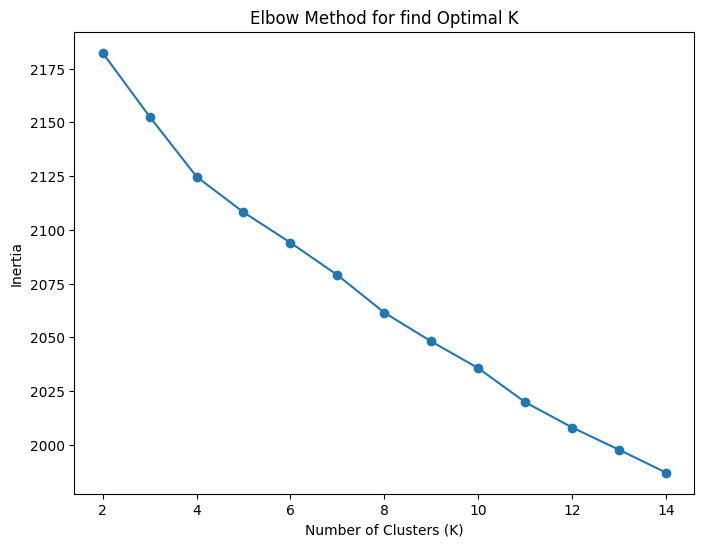

In [79]:
inertia = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for find Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()